In [17]:
from load_data import loading_and_pre_processing_pipeline

feature_data = loading_and_pre_processing_pipeline()
cleaned_feature_data = feature_data.dropna(axis=0)

print(f'{len(feature_data)} records from {len(set(cleaned_feature_data["user_id"].values))} users present. ')
print(f'{len(cleaned_feature_data)} of which are complete.')

288087 records from 7236 users present. 
62313 of which are complete.


In [18]:

import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

from sklearn.linear_model import LogisticRegression
from typing import List

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector

from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline

num_pipe = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=False),
    OrdinalEncoder(),
)

preprocessor_linear = make_column_transformer(
    [num_pipe, selector(dtype_include="number")],
    [cat_pipe, selector(dtype_include="object")],
    n_jobs=2,
)

preprocessing_pipeline = make_pipeline_with_sampler(
    preprocessor_linear,
    PolynomialFeatures()
)

lr_clf = make_pipeline_with_sampler(
    preprocessor_linear,
    PolynomialFeatures(),
    LogisticRegression(max_iter=1000, class_weight='balanced'),
)


def train_model(features: List[str], target: str, data: pd.DataFrame, random_state=42):

    for feature in features:
        assert feature in data.columns.values

    assert target in data.columns.values

    # cleaned_data = data.dropna(axis=0, subset=features + [target])

    gsp = GroupShuffleSplit(test_size=.33, n_splits=1, random_state=random_state)
    split = gsp.split(data, groups=data['user_id'])
    train, test = next(split)

    training_data = data.iloc[train]
    testing_data = data.iloc[test]

    X = training_data[features]
    y = training_data[target].astype(int)

    # pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe = lr_clf
    pipe.fit(X, y)

    return pipe, testing_data[features], testing_data[target].astype(int), test

/home/kolb/.cache/pypoetry/virtualenvs/ml-nowcasting-jKKypzXv-py3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



Text(0, 0, '17146')


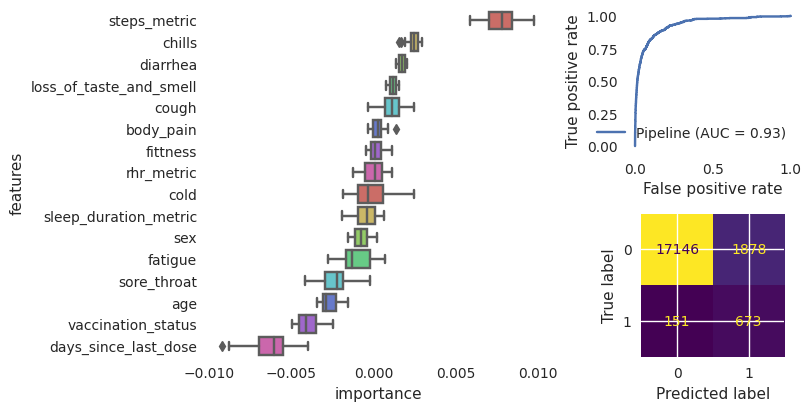

In [20]:
from analysis_plots import plot_analysis

feature_names = [
    "rhr_metric",
    "steps_metric",
    "sleep_duration_metric",
    "days_since_last_dose",
    "vaccination_status",
    "fittness",
    "sex",
    "age",
    "chills",
    "body_pain",
    "loss_of_taste_and_smell",
    "fatigue",
    "cough",
    "cold",
    "diarrhea",
    "sore_throat",
]
target = 'test_result'

pipeline, X_test, y_test, _ = train_model(feature_names, target, cleaned_feature_data)

fig = plot_analysis(pipeline, X_test, y_test, feature_names, 0.5)

fig.savefig('model_metrics.png', dpi=300)

In [21]:
import os
from datetime import datetime
from load_data import notebook_path

# Load reported incidences from File
online_source = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Inzidenz_Impfstatus.xlsx?__blob=publicationFile'



local_source = os.path.join(os.path.dirname(notebook_path), 'Inzidenz_Impfstatus.xlsx')


def load_excel(path):
    data = pd.read_excel(
        path,
        sheet_name=1, header=3
    )[['Mit Auffrischimpfung 18-59 Jahre', 'Grundimmunisierte  18-59 Jahre', 'Ungeimpfte 18-59 Jahre'
        , 'Meldejahr', 'Meldewoche']]
    data['date'] = data.apply(
        lambda row: datetime.strptime(str(row['Meldejahr']) + "-" + str(row['Meldewoche']) + '-1', "%Y-%W-%w"),
        axis=1)
    return data[data['Mit Auffrischimpfung 18-59 Jahre'] != '--'].drop(columns=['Meldejahr', 'Meldewoche'])


try:
    reported_incidence = load_excel(online_source)
except Exception as e:
    print('online source not available', e)
    reported_incidence = load_excel(local_source)
reported_incidence.head()

online source not available HTTP Error 403: Forbidden


,Mit Auffrischimpfung 18-59 Jahre,Grundimmunisierte 18-59 Jahre,Ungeimpfte 18-59 Jahre,date
14,29.961304,57.142708,177.065964,2021-10-18
15,44.699871,77.397034,228.247223,2021-10-25
16,44.969006,95.132538,268.383270,2021-11-01
17,59.339779,120.781189,329.819214,2021-11-08
18,63.652508,144.439636,359.598816,2021-11-15


In [22]:
import ramda as R
from datetime import timedelta
from numpy import random
MEAN_DAYS = 7


@R.curry
def predicted_incidence(classifier, feature_data, threshold):
    data = feature_data.set_index(['user_id', 'date'])

    proba_infected = classifier.predict_proba(data[feature_names]).T[1].T

    p = pd.DataFrame(
        data=proba_infected, index=data.index, columns=["probability"]
    )

    colname = f"{MEAN_DAYS}d rolling mean detections"

    p[colname] = p["probability"] > threshold

    p['all'] = p['probability'] > 0

    # if individuals are detected as infected in more than one week, take only the first detection
    only_first_positive_detections = (p[p[colname] == True]
                                      .reset_index()
                                      .sort_values(['user_id', 'date'])
                                      .groupby(['user_id'])
                                      .agg({colname: 'first', 'all': 'first', 'date': lambda x: list(x)[0]})
                                      .reset_index()
                                      )
    all_negative_detections = p[p[colname] == False].reset_index()

    detected_infections = pd.concat([only_first_positive_detections, all_negative_detections])

    detected_infections['date'] = detected_infections['date'].apply(
        lambda d: d + timedelta(days=int(random.randint(0, 7, 1))))

    rolling_mean_detections = (
        detected_infections
            .groupby("date")
            .sum()
            .rolling(f'{MEAN_DAYS}D').mean()
            .drop(columns=["probability", "user_id"])
    )

    rolling_mean_detections[colname] = rolling_mean_detections[colname].div(rolling_mean_detections['all'],
                                                                            axis=0) * 100_000

    return rolling_mean_detections.reset_index(), colname


def predict_incidence_runs(cleaned_feature_data: pd.DataFrame, feature_names, threshold=0.2) -> pd.DataFrame:
    runs = []
    for i in range(10):
        predictor, _, __, test_indices = train_model(feature_names, target, cleaned_feature_data, random_state=i)

        nowcasted_incidence, predicted_incidence_column = predicted_incidence(predictor,
                                                                              cleaned_feature_data.iloc[test_indices],
                                                                              threshold)
        nowcasted_incidence['run_id'] = i
        runs.append(
            nowcasted_incidence[[predicted_incidence_column, 'run_id', 'date']])

    predicted_incidence_runs = pd.concat(runs).reset_index().sort_values('date')

    predicted_incidence_plot_data = predicted_incidence_runs.groupby('date').agg(
        {predicted_incidence_column: ['mean', 'std']}).reset_index()

    predicted_incidence_plot_data.columns = ['date', 'mean', 'std']
    return predicted_incidence_plot_data

In [23]:
def calculate_questionnaire_incidence(cleaned_feature_data: pd.DataFrame) -> pd.DataFrame:
    res1 = cleaned_feature_data.replace({True: 1, False: 0, None: 0, float('nan'): 0}).reset_index()[
        ['test_result', 'date', 'user_id']]
    res2 = res1.groupby('date').agg({'test_result': ['sum', 'count']})
    res2.columns = res2.columns.droplevel(0)
    res2['rate'] = res2['sum'].div(res2['count'])
    res2['incidence'] = res2.rolling('7D')['rate'].mean() * 100_000
    questionnaire_incidence = res2.reset_index().dropna(axis=0)[['incidence', 'date']]
    questionnaire_incidence['date'] = questionnaire_incidence['date'] + timedelta(days=7)
    return questionnaire_incidence

In [24]:
import plotly.graph_objects as go
from datetime import date

SKIP_DAYS = 5

#Delta
# threshold=0.5
# after = cleaned_feature_data[['date']] > pd.to_datetime(date(year=2021, month=11, day=1))
# before = cleaned_feature_data[['date']] < pd.to_datetime(date(year=2022, month=1, day=1))

#Omicron
# threshold = 0.5
# after = cleaned_feature_data[['date']] > pd.to_datetime(date(year=2022, month=2, day=1))
# before = cleaned_feature_data[['date']] < pd.to_datetime(datetime.now().date())

# Omicron BA1
# threshold = 0.12
# after = cleaned_feature_data[['date']] > pd.to_datetime(date(year=2022, month=1, day=1))
# before = cleaned_feature_data[['date']] < pd.to_datetime(date(year=2022, month=3, day=1))

# Omicron BA2
# threshold = 0.32
# after = cleaned_feature_data[['date']] > pd.to_datetime(date(year=2022, month=3, day=1))
# before = cleaned_feature_data[['date']] < pd.to_datetime(datetime.now().date())

# All
threshold=0.6
after = cleaned_feature_data[['date']] > pd.to_datetime(date(year=2021, month=11, day=1))
before = cleaned_feature_data[['date']] < pd.to_datetime(datetime.now().date())

working_data = cleaned_feature_data[(before & after).values]

questionnaire_incidence = calculate_questionnaire_incidence(working_data)
predicted_incidence_plot_data = predict_incidence_runs(working_data, feature_names, threshold)

default_layout = {
    "title": {"y": 0.97, "x": 0.5, "xanchor": "center", "yanchor": "top"},
    "font_size": 12,
    "autosize": True,
    "height": 600,
    "margin": dict(l=60, r=30, b=75, t=80, pad=0),
    "template": "plotly_white",
    "hovermode": "x",
    "legend": {
        "font_size": 11,
        'x': 0,
        'y': 1,
        "itemclick": "toggleothers",
        "itemdoubleclick": "toggle",
        "tracegroupgap": 2,
    },
    "hoverlabel": {"font_color": "white", "namelength": -1},
    "xaxis": {
        "showline": True,
        "linewidth": 1.5,
        "linecolor": "#455266",
        "ticks": "outside",
        "tickwidth": 1.5,
        "rangemode": "nonnegative",
    },
    "yaxis": {
        "showline": True,
        "linewidth": 1.5,
        "linecolor": "#455266",
        "ticks": "outside",
        "tickwidth": 1.5,
        "rangemode": "nonnegative",
    },
    "showlegend": True,
}

i18n = {
    'de': {
    'booster': 'Mit Auffrischimpfung 18-59 Jahre',
    'base': 'Grundimmunisierte  18-59 Jahre',
    'unvax': 'Ungeimpfte 18-59 Jahre',
    'title': 'Gemeldete Inzidenz vs. Machine Learning Nowcast',
    'y_axis_title': 'Inzidenz',
    'nowcast': 'Nowcast',
    'insecurity': 'Modell Unsicherheit'
    },
    'en': {
    'booster': 'With booster 18-59 years',
    'base': 'Vaccinated  18-59 years',
    'unvax': 'Unvaccinated 18-59 years',
    'title': 'Reported Incidence vs. Machine Learning Nowcast',
    'y_axis_title': 'Incidence',
    'nowcast': 'Nowcast',
    'insecurity': 'Confidence interval'
    }
}

for language, translation in i18n.items():
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=predicted_incidence_plot_data['mean'].values[SKIP_DAYS:] + 2 * predicted_incidence_plot_data['std'].values[
                                                                         SKIP_DAYS:],
        x=predicted_incidence_plot_data['date'].values[SKIP_DAYS:],
        showlegend=False,
        legendgroup='nowcast',
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        hoverinfo='skip'
    ))
    fig.add_trace(go.Scatter(
        name=translation['insecurity'],
        y=predicted_incidence_plot_data['mean'].values[SKIP_DAYS:] - 2 * predicted_incidence_plot_data['std'].values[
                                                                         SKIP_DAYS:],
        x=predicted_incidence_plot_data['date'].values[SKIP_DAYS:],
        showlegend=False,
        legendgroup='nowcast',
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(65, 172, 221, 0.3)',  #'rgba(68, 68, 68, 0.3)'
        fill='tonexty',
        hoverinfo='skip'
    ))

    fig.add_trace(go.Scatter(
        y=predicted_incidence_plot_data['mean'].values[SKIP_DAYS:-1],
        x=predicted_incidence_plot_data['date'].values[SKIP_DAYS:-1],
        name=translation['nowcast'],
        legendgroup='nowcast',
        mode='lines',
        hovertemplate="%{y:.0f}",
        line=dict(width=2.5,
                  color='#41ACDD'  #455266
                  )))

    fig.add_trace(go.Scatter(
        y=questionnaire_incidence['incidence'].values[:-1],
        x=questionnaire_incidence['date'].values[:-1],
        name='questionnaire incidence',
        legendgroup='nowcast',
        mode='lines',
        hovertemplate="%{y:.0f}",
        line=dict(width=2.5,
                  color='red'  #455266
                  )))

    fig.add_trace(go.Scatter(
        y=reported_incidence['Mit Auffrischimpfung 18-59 Jahre'].values[1:],
        x=reported_incidence['date'].values[1:],
        name=translation['booster'],
        mode='markers',
        hovertemplate="%{y:.0f}",
        marker=dict(size=8,
                    color='white',  #41ACDD
                    line=dict(width=2., color='red')  #DarkSlateGrey
                    )))

    fig.add_trace(go.Scatter(
        y=reported_incidence['Grundimmunisierte  18-59 Jahre'].values[1:],
        x=reported_incidence['date'].values[1:],
        name=translation['base'],
        mode='markers',
        hovertemplate="%{y:.0f}",
        marker=dict(size=9,
                    color='red',  #455266
                    # line=dict(width=1.5, color='DarkSlateGrey')
                    )
    ))

    fig.add_trace(go.Scatter(
        y=reported_incidence['Ungeimpfte 18-59 Jahre'].values[1:],
        x=reported_incidence['date'].values[1:],
        name=translation['unvax'],
        mode='markers',
        hovertemplate="%{y:.0f}",
        marker=dict(size=9,
                    color='#455266',  #red
                    # line=dict(width=1.5, color='DarkSlateGrey')
                    )))

    layout = dict(
        title_text=translation['title'],
        yaxis_title=translation['y_axis_title'],
        hovermode='x unified',
        hoverlabel={'font': {
            'color': 'black',
        }},
    )
    fig.update_layout(default_layout)
    fig.update_layout(layout)
    fig.write_html(f'incidence_nowcast_{language}.html', include_plotlyjs='cdn', full_html=False,
                   config={'responsive': 'true', 'displayModeBar': False})

fig.write_image(f"incidence_nowcast.png")
fig.show()